# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [3]:
# import libraries
from pyspark.sql import SparkSession
from pyspark import SparkConf
from pyspark.sql.functions import udf
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import isnan, count, when, col, desc, udf, col, sort_array, sum,  asc, avg
from pyspark.sql.functions import sum as Fsum
from pyspark.sql.functions import when, col
from pyspark.sql.window import Window
from pyspark.sql import Row
import datetime

import pyspark
import pandas as pd
import numpy as np



In [4]:
# create a Spark session
spark = SparkSession\
.builder\
.appName('Sparkify')\
.getOrCreate()

In [5]:
spark.sparkContext.getConf().getAll()

[('spark.driver.extraJavaOptions',
  '-XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED'),
 ('spark.app.id', 'local-1679164664620'),
 ('spark.executor.id', 'driver'),
 ('spark.app.startTime', '1679164664101'),
 ('spark.sql.warehouse.dir',
  'file:/Users/Moaze002/Documents/Udacity-DataScience%20Nanodegree/notebooks/Project%

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [6]:
data = spark.read.json("/Users/Moaze002/Documents/Udacity-DataScience Nanodegree/notebooks/Project 4/mini_sparkify_event_data.json")

In [7]:
data.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [8]:
data.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
data.describe()


DataFrame[summary: string, artist: string, auth: string, firstName: string, gender: string, itemInSession: string, lastName: string, length: string, level: string, location: string, method: string, page: string, registration: string, sessionId: string, song: string, status: string, ts: string, userAgent: string, userId: string]

In [10]:
data.count()

286500

In [11]:
data.select("userId").dropDuplicates().sort("userId").show(10)

+------+
|userId|
+------+
|      |
|    10|
|   100|
|100001|
|100002|
|100003|
|100004|
|100005|
|100006|
|100007|
+------+
only showing top 10 rows



In [12]:
data.select("sessionId").dropDuplicates().sort("sessionId").show(10)

+---------+
|sessionId|
+---------+
|        1|
|        2|
|        3|
|        4|
|        5|
|        6|
|        7|
|        8|
|        9|
|       10|
+---------+
only showing top 10 rows



In [13]:
data = data.dropna(how = 'any', subset = ["userId"])

In [14]:
number_of_rows = data.count()

In [15]:
data = data.filter(data["userId"] != "")

In [16]:
# loop over each column and count duplicates
for column in data.columns:
    duplicates = data.groupBy(column).agg(count("*").alias("count")).filter("count > 1")
    duplicates.show()


+--------------------+-----+
|              artist|count|
+--------------------+-----+
|      The Black Keys| 1125|
|         Silverstein|   60|
|           Kate Nash|   99|
|        Yann Tiersen|  139|
|    Jane's Addiction|   68|
|          Tim Hughes|   39|
|          Carl Craig|    3|
|Dashboard Confess...|   98|
|Yonder Mountain S...|   63|
|           Los Lobos|   45|
|Pete Rock & C.L. ...|    2|
|        Ziggy Marley|   28|
|      Jarabe De Palo|   83|
|               Rufio|   13|
|      Jorge Gonzalez|   24|
|                Silk|   22|
|  The Watts Prophets|    6|
|            La Shica|    2|
|        Generation X|   19|
|    The Flower Kings|    4|
+--------------------+-----+
only showing top 20 rows

+---------+------+
|     auth| count|
+---------+------+
|Cancelled|    52|
|Logged In|278102|
+---------+------+

+----------+-----+
| firstName|count|
+----------+-----+
|    Maddox|  201|
|    Karter| 3014|
|   Lorelei| 1347|
|  Isabella|  910|
|  Giovanni|  837|
|     Davis

In [17]:
data_no_duplicated = data.select("*").dropDuplicates()


# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [18]:
# flag the records where Cancellation Confirmation page is reached - 1 if it is and 0 if not
churn_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())

#creating churn column
data_churn = data_no_duplicated.withColumn("Churn", churn_event("page"))


Now this is very crucial step: Since all users are all `Churn == 0` and then in a time they become 1, so we have to make the churn to the sum of the value

In [19]:
# sort records for a user in reverse time order so we can add up vals in churn column
W = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)

# create column churn which contains sum of churn 1s over records
data_churn = data_churn.withColumn("Churn", Fsum("Churn").over(W))

In [20]:
data_pd = data_churn.toPandas()

In [21]:
data_pd['Churn'].value_counts().to_frame().style.background_gradient()


,Churn
0,233290
1,44864


In [22]:
data_pd.head()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,Churn
0,None,Logged In,Darianna,F,34,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",PUT,Logout,1538016340000,187,None,307,1542823952000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
1,Lily Allen,Logged In,Darianna,F,33,Carpenter,185.25995,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,22,200,1542823951000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
2,John Waite,Logged In,Darianna,F,32,Carpenter,269.76608,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,Missing You,200,1542823682000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
3,Hermano,Logged In,Darianna,F,31,Carpenter,115.90485,free,"Bridgeport-Stamford-Norwalk, CT",PUT,NextSong,1538016340000,187,Letters From Madrid,200,1542823567000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0
4,None,Logged In,Darianna,F,30,Carpenter,NaN,free,"Bridgeport-Stamford-Norwalk, CT",GET,Roll Advert,1538016340000,187,None,200,1542823257000,"""Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like...",100010,0


In [23]:
print(f"Percentage of records that is omitted becuase of empty id is: {(number_of_rows - data_pd.shape[0])/data_pd.shape[0] }")

Percentage of records that is omitted becuase of empty id is: 0.03000496128044177


In [24]:
data_pd[data_pd['Churn']==1].userId.count()

# Number of churn customers 😞

44864

In [25]:
data_pd.shape

(278154, 19)

In [26]:
data_pd.isnull().sum()

artist           50046
auth                 0
firstName            0
gender               0
itemInSession        0
lastName             0
length           50046
level                0
location             0
method               0
page                 0
registration         0
sessionId            0
song             50046
status               0
ts                   0
userAgent            0
userId               0
Churn                0
dtype: int64

In [27]:
data_pd.dropna(inplace=True)

In [28]:
data_pd.shape

(228108, 19)

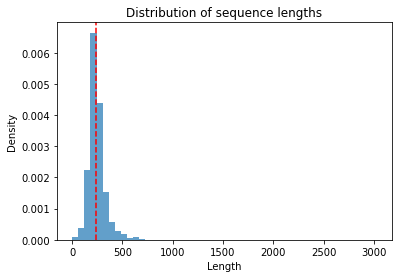

In [29]:
# create a density plot
plt.hist(data=data_pd, x='length', bins=50, density=True, alpha=0.7
        )

# add a vertical line at the median length
median_length = data_pd['length'].median()
plt.axvline(median_length, color='red', linestyle='--')

# set the x and y labels
plt.xlabel('Length')
plt.ylabel('Density')

# add a title
plt.title('Distribution of sequence lengths')

# show the plot
plt.show()

In [30]:
df_col = data_churn.select(['userId', 'Churn', 'page']).dropDuplicates().groupBy(['Churn', 'page']).count()
df_col.show(40)

+-----+--------------------+-----+
|Churn|                page|count|
+-----+--------------------+-----+
|    0|       Save Settings|  102|
|    1|           Thumbs Up|   50|
|    1|          Add Friend|   44|
|    1|     Add to Playlist|   50|
|    0|            Settings|  152|
|    0|          Add Friend|  162|
|    1|             Upgrade|   37|
|    1|              Logout|   46|
|    1|    Submit Downgrade|    9|
|    1|         Thumbs Down|   48|
|    1|                Help|   43|
|    1|           Downgrade|   35|
|    1|               Error|   22|
|    0|               Error|   95|
|    0|                Help|  149|
|    0|         Thumbs Down|  155|
|    0|    Submit Downgrade|   40|
|    1|            Settings|   43|
|    0|            NextSong|  173|
|    0|           Downgrade|  119|
|    0|         Roll Advert|  157|
|    1|      Submit Upgrade|   29|
|    1|                Home|   51|
|    1|         Roll Advert|   50|
|    0|      Submit Upgrade|  102|
|    0|             

In [31]:
# define the window specification
window = Window.partitionBy("userId") \
               .orderBy(desc("ts")) \
               .rangeBetween(Window.unboundedPreceding, 0)

# add a new column to the dataframe, called "Churn"
# this column contains the cumulative sum of the "Churn" column for each user, sorted in reverse time order
data_churn = data_churn.withColumn("Churn", sum("Churn").over(window))

In [ ]:
# get all columns except for userId and churn
columns = ['gender', 'level','page']


# create subplots
fig, axs = plt.subplots(ncols=len(columns), figsize=(18, 6))

# iterate over columns and create a bar plot for each one
for i, col in enumerate(columns):
    # group by column and churn and count
    df_col = data_churn.select(['userId', 'Churn', col]).dropDuplicates().groupBy(['Churn', col]).count()
    # collect data as a list of rows
    rows = df_col.collect()
    # convert rows to a list of dictionaries
    data = [{col: r[col], 'count': r['count'], 'Churn': r['Churn']} for r in rows]
    # set order for plotting
    data = sorted(data, key=lambda x: x['count'], reverse=True)
    # plot bar chart
    ax = sns.barplot(x=col, y='count', hue='Churn', data=pd.DataFrame(data), ax=axs[i],
                    palette=['green', 'red'])
    # set title
    ax.set_title(f'Number of Users That Churned by {col}')
    # set legend
    ax.legend(title='Churn', loc='best', labels=['Not Churned', 'Churned'])
    # set xlabel rotation
    ax.tick_params(axis='x', rotation=90)

# set overall title
fig.suptitle('Churn by User Attributes')
# adjust spacing between subplots
fig.tight_layout()


In [ ]:
group_by_page = data_churn.select(['userId', 'Churn', 'page'])\
.groupBy('page','Churn')\
.count()\
.toPandas() 

In [ ]:
# calculate counts of customers who churned and those who stayed
churn_count = group_by_page.loc[group_by_page['Churn'] == 1, 'count'].sum()
stay_count = group_by_page.loc[group_by_page['Churn'] == 0, 'count'].sum()

# calculate the rate of pages visited by those who churned vs. those who stayed
group_by_page['rate'] = group_by_page['count'] / np.where(
    group_by_page['Churn'] == 0, stay_count, churn_count)
group_by_page


In [ ]:
# plot the pages by churn
plt.figure(figsize=[10,8])
ax = sns.scatterplot(data=group_by_page, x='rate', y='page', hue='Churn', s=200)

plt.title('Rate of Pages Navigated to by Users that Churned vs. Users that Stayed')
plt.xlabel('Rate of pages visited')
plt.ylabel('Page')
plt.show()


In [ ]:
# define a UDF to extract the hour from the timestamp
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)

# create a new column for the hour
df = data_churn.withColumn("hour", get_hour(data_churn.ts))

# filter the data for users who did not churn and navigated to the NextSong page
songs_in_hour_stay = df.filter((df.page == "NextSong") )

# group by hour and count the number of NextSong pages
songs_in_hour_stay = songs_in_hour_stay.groupBy(["hour", "Churn"]).count()

# sort the data by hour as a float
songs_in_hour_stay = songs_in_hour_stay.orderBy(col("hour").cast("float"))

# convert the data to a pandas dataframe
songs_in_hour_stay_pd = songs_in_hour_stay.toPandas()

# convert the hour column to numeric data type
songs_in_hour_stay_pd["hour"] = pd.to_numeric(songs_in_hour_stay_pd["hour"])


In [ ]:
songs_in_hour_stay_pd

In [ ]:
#plot the distribution
plt.figure(figsize=[10, 8])
sns.lineplot(data=songs_in_hour_stay_pd, x='hour', y='count', hue = "Churn")
plt.xlim(-1, 24)
plt.xlabel("Hour")
plt.ylabel("Songs played")
plt.title("Number of Songs Played per Hour ( Churn & Non-Churn Users)");


This is somewhat what we expect!

In [ ]:

df_opsys = data_churn.select("userId", "userAgent", "Churn").dropDuplicates(['userId']).toPandas()

# List of browsers to extract
browser_list = ["Chrome", "Firefox", "Safari", "Trident"]

# Extract the browser from the user agent string and create a new column
df_opsys['browser'] = df_opsys.userAgent.str.extract('(?i)({0})'.format('|'.join(browser_list)))

# Group the data by OS and browser and get the count
grouped_data = df_opsys.groupby(['Churn', 'browser']).size().unstack()

# Plot a bar chart for each group
grouped_data.plot(kind='bar', layout=(2,2), figsize=(10,8))

# Show the plot
plt.show()



In [ ]:
# Subtract registration from ts and create a new column
days_df = data_churn.withColumn("diif_days", (data_churn['ts']) - (data_churn['registration']))

# Convert delta_days to days and create a new column
days_df_pd = days_df.withColumn("days", days_df['diif_days']/(1000*3600*24)).toPandas()

# # Create the violin plot
plt.figure(figsize=[8,6])
sns.violinplot(data=days_df_pd, x='Churn', y='days')
plt.title('Count of Users that Churned vs. Users that Stayed by Days Since Registering')
plt.ylabel("Days Since Registered")

# Show the plot
plt.show()



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

#### Gender

In [ ]:
data_gender = data_churn\
.select(['userId', 'gender'])\
.dropDuplicates()\
.withColumn('gender', when(col('gender') == 'M', 1)\
.otherwise(0))

In [ ]:
data_gender.show(10)

In [ ]:
from pyspark.sql.functions import dense_rank
data_level = data_churn.select(['userId', 'level', 'ts']) \
.dropDuplicates() \
.sort('userId') \
.withColumn("uptodate", dense_rank() \
.over(Window.partitionBy("userId") \
.orderBy(desc("ts")))) 

In [ ]:
data_level.show(10)

In [ ]:
data_level_f = data_level \
.filter(data_level.uptodate==1) \
.drop('ts', 'uptodate') \
.withColumn('level', when(col('level') == 'paid', 1).otherwise(0))
 

In [ ]:
data_level_f.show(10)

In [ ]:
data_artist = data_churn\
.select("userId", "artist")\
.dropDuplicates()\
.groupby("userId")\
.count()\
.withColumnRenamed("count", "number_artist_listen")



In [ ]:
data_artist.show(10)

In [ ]:
data_song = data_churn\
.select(["userId", "page"]) \
.withColumn("n_song", when(col("page") == "NextSong", 1).otherwise(0)) \
.groupBy("userId") \
.agg({'n_song': 'avg'}) \
.withColumnRenamed('avg(n_song)', 'nsong')

In [ ]:
data_song.show()

In [ ]:
data_playlist = data_churn\
.select(["userId", "page"]) \
.withColumn("p_list", when(col("page") == "Add to Playlist", 1).otherwise(0)) \
.groupBy("userId") \
.agg({'p_list': 'count'}) \
.withColumnRenamed('count(p_list)', 'p_list')

In [ ]:
data_ad = data_churn\
.select(["userId", "page"]) \
.withColumn("ad", when(col("page") == "Roll Advert", 1).otherwise(0)) \
.groupBy("userId") \
.agg({'ad': 'sum'}) \
.withColumnRenamed('sum(ad)', 'ad')

In [ ]:
data_playlist.show(10)

In [ ]:
data_ad.show(10)

In [ ]:
data_likes = data_playlist = data_churn\
.select(["userId", "page"]) \
.withColumn("n_like", when(col("page") == "Thumbs Up", 1).otherwise(0)) \
.groupBy("userId") \
.agg({'n_like': 'sum'}) \
.withColumnRenamed('sum(n_like)', 'thumbsup')

In [ ]:
data_likes.show(10)

In [ ]:
data_dlikes =  data_churn\
.select(["userId", "page"]) \
.withColumn("n_dlike", when(col("page") == "Thumbs Down", 1).otherwise(0)) \
.groupBy("userId") \
.agg({'n_dlike': 'sum'}) \
.withColumnRenamed('sum(n_dlike)', 'thumsdown')

In [ ]:
data_dlikes.show(10)

In [ ]:
data_dgrade =  data_churn\
.select(["userId", "page"]) \
.withColumn("n_dgrade", when(col("page") == "Downgrade", 1).otherwise(0)) \
.groupBy("userId") \
.agg(sum("n_dgrade").alias("dgrade"))


In [ ]:
data_dgrade.show()

In [ ]:
data_c = data_churn\
.select("userId", "Churn")\
.dropDuplicates()\
.groupby("userId", "Churn")\
.count()\
.drop('count')

In [ ]:
df_ready = data_gender\
.join(data_level_f, ["userId"])\
.join(data_artist, ["userId"])\
.join(data_playlist, ["userId"])\
.join(data_likes, ["userId"])\
.join(data_dlikes, ["userId"])\
.join(data_dgrade, ["userId"])\
.join(data_song, ["userId"])\
.join(data_ad , ["userId"])\
.join(data_c, ["userId"]) \
.dropDuplicates()


In [ ]:
df_ready.show()

In [ ]:
df_ready.printSchema()


In [ ]:
float_cols = [col(c).cast('float').alias(c) for c in df_ready.columns]
df_ready = df_ready.select(float_cols)

In [ ]:
df_ready.printSchema()

In [ ]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

# Select columns to be scaled and assemble them into a single vector column
assembler = VectorAssembler(inputCols=['gender', 'level', 'number_artist_listen', 'p_list',
                                      'thumbsup', 'thumbsdown', 'dgrade', 'nsong', 'ad','Churn'],
                            outputCol='features_vec')


In [ ]:
df_assembled = assembler.transform(df_ready)

# Fit StandardScaler model on assembled data
scaler = StandardScaler(inputCol='features_vec', outputCol='scaled_features')
scaler_model = scaler.fit(df_assembled)

# Apply scaler model on assembled data
df_scaled = scaler_model.transform(df_assembled)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.